## Clustering
- Goals: partition the data into distinct sub-groups or clusters such that observations belonging to the same cluster are more similar to each other than to those in other clusters

1. First, we identify the direct identifier and delete them 
2. Secondly, we identify numerical quasi identifiers for our clustering
   - numerical: age, height, weight (of course there are more, but for our purpose these are sufficient)

The code below imports the pandas library, reads a CSV file into a DataFrame, filters out rows with "NA" in the 'name' column, identifies sensitive columns, and fills missing values with 0.

In [9]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('reduced_athletes.csv', low_memory=False)
df = df[df['name'] != "NA"]
df = df.drop(columns=['name', 'athlete_id'])
# Identify sensitive columns that need to be anonymized
sensitive_columns = ['age', 'weight', 'height', 'region']
df['age'] = df['age'].fillna(df['age'].mean())
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['height'] = df['height'].fillna(df['height'].mean())
df['region'] = df['region'].fillna(df['region'].mode()[0])

From the sklearn library the KMeans algorithm is used to partition the scaled data into 7 clusters. The fit_predict() function is used to compute the centroids of the clusters and assign each data point to the nearest cluster. The cluster assignments are then added to the DataFrame as a new 'cluster' column. The size of k has to be decided and can impact results. If the k is too small, the algorithm might not capture the complexity of the data. If k is too large, it might overfit the data, capturing noise and outliers.

In [10]:

# Feature scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[sensitive_columns[:-1]])  # Exclude 'region' from scaling

# Clustering
kmeans = KMeans(n_clusters=7)
clusters = kmeans.fit_predict(df_scaled)
df['cluster'] = clusters

C:\Users\Julius\PycharmProjects\PPOD\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For each unique cluster, the indices of the rows belonging to that cluster are identified. Then, for each sensitive column, if the column is not 'region', the actual values are replaced with the mean value of that column in the current cluster. For each cluster the region column the most common non-zero, non-'NaN' value in the current cluster is identified. If such a value exists, all 'region' values in the current cluster are replaced with this most common value.

In [11]:

for cluster in df['cluster'].unique():
    cluster_indices = df[df['cluster'] == cluster].index
    for column in sensitive_columns:
        if column != 'region':
            # Apply your anonymization technique here
            df.loc[cluster_indices, column] = df.loc[cluster_indices, column].mean()
        else:
            # Find the most common non-zero, non-'NaN' value for 'region' in the current cluster
            mode_values = df.loc[cluster_indices, 'region'].replace([0, 'NaN', 'NA'], np.nan).mode()
            if not mode_values.empty:
                most_common_region = mode_values.iloc[0]
                df.loc[cluster_indices, 'region'] = most_common_region
            # Replace 'region' values in the current cluster with the most common value
            df.loc[cluster_indices, 'region'] = most_common_region

This whole section is for visualizing the distribution of entries across the clusters. 

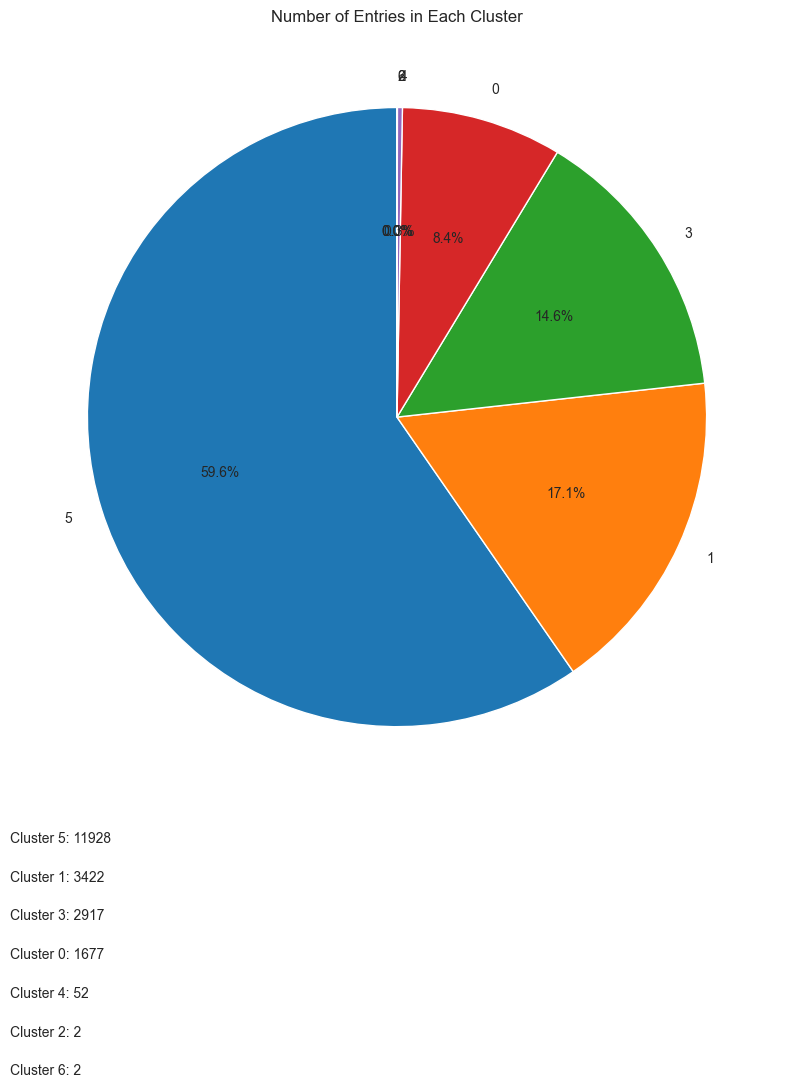

             age       weight      height      region
0      26.586499   178.158058   69.866279  North East
1      41.738087   185.519400   70.222037  North East
2      33.439364   185.879183   70.176269  North East
5      33.016696   224.025641   73.401692  North East
2361   32.500000   174.800609    6.288462  North East
6157   33.500000  1994.000000   35.500000  North East
10820  36.000000   396.000000  298.500000  North East


In [12]:

# Count the number of entries in each cluster
cluster_counts = df['cluster'].value_counts()

# Plot the counts in a pie chart
fig, ax = plt.subplots(figsize=(18, 18))
ax.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Number of Entries in Each Cluster')

# Display the count of each cluster below the pie chart
for i, (cluster, count) in enumerate(cluster_counts.items(), start=1):
    plt.annotate(f"Cluster {cluster}: {count}", xy=(0, -0.05*i), xycoords='axes fraction')

# Adjust the subplot parameters so that the subplot fits into the figure area
plt.subplots_adjust(bottom=0.1 + 0.05*len(cluster_counts))

# Show the plot
plt.show()



# Drop the cluster column if it's no longer needed
df.drop('cluster', axis=1, inplace=True)

# Save or return the anonymized dataset
df_unique = df[sensitive_columns].drop_duplicates()

# Display the unique rows
print(df_unique)
df.to_csv('cluster.csv', index=False)

